<h1 align="center">Advanced Statistical Machine Learning & Pattern Recognition - CO495</h1> 
<h2 align="center">Coursework #1: Gaussian Mixture Model</h2> 
<h3 align="center">Ilaria Manco</h3> 

In [1]:
import h5py
from scipy.io import savemat
import numpy as np
import csv
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal as mvn
from sklearn.cluster import KMeans
try:
    %matplotlib inline
except NameError:
    # this is a terminal, that's fine.
    pass

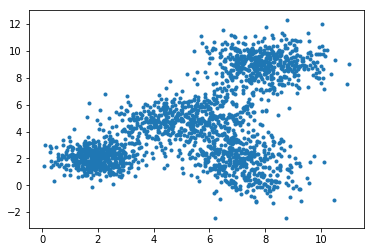

In [2]:
# load the file.
f = h5py.File('X.mat')
f.keys()

X = f.get('X').value

data = X
# optionally visualise the X matrix.
try:
    plt.plot(data[0, :], data[1, :], '.')
except:
    pass

# EM Init

The parameters can be initialised in two ways: at **random** or by running the **k-means** algorithm on the dataset and then using the mixing coefficients and the sample means and covariances as the initial parameters for the GMM.

In [3]:
def RandomEMInit(K):
    params = random_params_generator(K)
    return params

The code below uses the scikit-learn KMeans. The means ${\mu_k}$ and the covariance matrices ${\Sigma_k}$ are initialised to the centres and the sample covariances of the clusters respectively, while the mixing coefficients $\pi_k$ are set to the proportion of data points within the respective cluster $k$.

In [4]:
def k_meansInit(X, K):
    kmeans = KMeans(n_clusters=K)
    labels = kmeans.fit_predict(X.T)
    means = kmeans.cluster_centers_
    
    params = {}
    clusters = []
    for i in range(1, K + 1):
        clusters += [X.T[np.where(labels == i-1)]]
        
        nn = 'means_{}'.format(i)
        params[nn] = means[i-1]
        
        nn = 'covars_{}'.format(i)
        params[nn] = np.cov(clusters[i-1].T)

        nn = 'mixCoeff_{}'.format(i)
        params[nn] = (np.count_nonzero(labels == i-1))/len(X[0])
    
    return params

# EM E step

This is the implementation of the expectation step. 

This uses the current parameter values (the initialisation ones at the first iteration, then the parameters evaluated by the maximisation step at each following iteration), to evaluate the responsibilities

$$\gamma_{nk} = \frac{\pi_k N(x_n| \mu_k, \Sigma_k)}{\sum_l^4 \pi_l N(x_n| \mu_l, \Sigma_k)}$$

In [28]:
def EMEStep(data, K, params):
    N = len(data[0])
    resp = np.ones((K, N))
    
    #select parameters based on k
    for k in range(K):
        means = params['means_{}'.format(k+1)]
        covars = params['covars_{}'.format(k+1)]
        mixCoeff = params['mixCoeff_{}'.format(k+1)]
        
    #evaluate the numerator of the responsibilities for each {n,k}
        for n in range(N):
            # Check if the matrix is positive semi-definite
            try:
                np.linalg.cholesky(covars)
                resp[k][n] = mixCoeff*mvn.pdf(data[:,n], means, covars)
            # If not, use the product of the matrix with its transpose    
            except:
                resp[k][n] = mixCoeff*mvn.pdf(data[:,n], means, np.dot(covars, covars.transpose()))
    
    resp = resp/sum(resp)
    return resp.T

# EM M step

This is the implementation of the maximisation step.

The function below returns a dictionary containing the new parameters evaluated at each iteration using the current responsibilities:
$$ \mu_k^{new} = \frac{\sum_{n=1}^N \gamma(z_{nk}) x_n}{\sum_{n=1}^N \gamma(z_{nk})} $$

$$\Sigma_k^{new} = \frac{\sum_{n=1}^N \gamma(z_{nk}) (x_n-\mu_k)(x_n-\mu_k)^T}{\sum_{n=1}^N \gamma(z_{nk})} $$

$$ \pi_k^{new} = \frac{\sum_{n=1}^{N} \gamma(z_{nk})}{N}. $$

In [29]:
def EMMStep(data, K, resp, params):
    N = len(data[0])
    new_params = {}
    
    for k in range(K):
        resp_sum = 0
        resp_x_sum = 0
        resp_outer = 0
        
        means = params['means_{}'.format(k+1)]  
        
        for n in range(N):
            #sum the responsibilities over n
            resp_sum += resp[n,k]     
            #sum the product of the responsibilities with the x_n over n
            resp_x_sum += resp[n,k]*data[:,n]
            # sum resp*outer product over n
            resp_outer += resp[n,k]*np.outer(data[:,n]-means, data[:,n]-means)
        
        nn = 'mixCoeff_{}'.format(k+1)
        new_params[nn] = resp_sum/N
        
        nn = 'means_{}'.format(k+1)
        new_params[nn] = resp_x_sum/resp_sum
        
        nn = 'covars_{}'.format(k+1)
        new_params[nn] = resp_outer/resp_sum
        
    return new_params

# GMM Demo

In [7]:
# aux functions
def random_params_generator(K):
    params = {}
    for i in range(1, K + 1):
        nn = 'means_{}'.format(i)
        rand = []
        for j in range(1000):
            rand += [np.random.rand(2)]
        params[nn] = sum(rand)/1000
        
        nn = 'covars_{}'.format(i)
        params[nn] = np.random.rand(2, 2)

        nn = 'mixCoeff_{}'.format(i)
        rand = []
        for j in range(1000):
            rand += [np.random.rand(1)]
        params[nn] = sum(rand)/1000
    return params


def convert_params_to_row(params, K):
    # accepts the params dict and converts it to a row to be exported.
    # The covars are flattened per row.
    row = []
    for var in ['means', 'covars', 'mixCoeff']:
        for i in range(1, K + 1):
            elems = params['{}_{}'.format(var, i)].flatten()
            row += [str(el) for el in elems]
    return row

In [22]:
def GMMDemo(X, K=4):
    # accepts a 2 dimensional matrix X with the observed 
    # data and the K, which represents the number of clusters.
    # Please do not modify it!
    #
    # initialise the parameters
    
    # comment out the next line for random initialisation:
    # params = RandomEMInit(K) 
    # k-means initialisation:
    params = k_meansInit(data, 4)     
        
    # params should be a dict() with the following format:
    # params['means_[i]'] -> [2x1 float] (i \in [1, K])
    # params['covars_[i]'] -> [2x2 float] (i \in [1, K])
    # params['mixCoeff_[i]'] -> [1x1 float] (i \in [1, K])
    
    # EM algorithm
    # do not change the iterations --- keep them fixed.
    for i  in range(10):
        # E step
        resp = EMEStep(X, K, params); # compute responsibilities, i.e., every \gamma(z_{n,k})

        # M step
        params = EMMStep(X, K, resp, params) # update the values for the parameters
        
    # comment out the line below once you have implemented 
    # the init code!
    # params = random_params_generator(K)
    # save the final values for the parameters
    # savemat('params.mat', {'params' : params})
    # export in csv.
    row = convert_params_to_row(params, K)
    with open('params.csv', 'w', encoding='utf-8-sig') as fn:
        writer = csv.writer(fn)
        writer.writerow(row)
    return params

# Visualisation 

The code below runs the GMM demo and evaluates the responsibilities using the parameters thus found.

In [31]:
params = GMMDemo(data)

In [24]:
K = 4
resp = EMEStep(data, K, params)

Now we can randomly sample from the distribution obtained through the EM algorithm. 

For each cluster $k$, we draw our $\mathbf{x_n}$ data points with probability equal to $\gamma_{nk}$.

In [30]:
N = len(data[0])
clusters = []
for n in range(N):
    prob = resp[n]
    #sampling
    which_cluster = np.random.choice(range(K), p = [prob[0], prob[1], prob[2], prob[3]]) 
    clusters.append(which_cluster)

Now we can visualise the result of the EM algorithm by plotting points corresponding to our data with different colours according to which sample they are assigned to in the step above.

The contours of constant probability density for the four Gaussians are also drawn on each cluster. This confirms our initial guess on the form of the covariance matrices (see Exercise I (a) on answers.pdf)

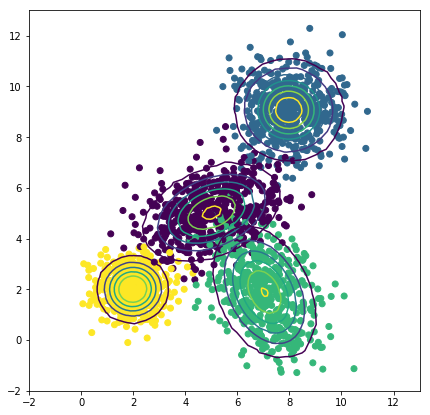

In [26]:
plt.figure(figsize=(7,7)) 
for i in range(1, K+1):
    means = params['means_{}'.format(i)]
    covars = params['covars_{}'.format(i)]
    z = mvn.pdf(data.T, means, covars)
    plt.tricontour(data[0, :], data[1, :], z)
    
plt.xlim(-2, 13)
plt.ylim(-2, 13)
plt.scatter(data[0, :], data[1, :], c = clusters) 
plt.show()